# EECS 198-071 Lab: Video Compression

Contributors: Shivin Devgon, Henry Muller, Dominic Carrano

In [1]:
!pip install pywavelets sk-video

  Using cached sk_video-1.1.10-py2.py3-none-any.whl (2.3 MB)


**NOTE:** The line `from IPython.display import Video` may fail. If so, comment it out and don't run the `Video([filepath])` lines; you can just view the video files outside the notebook.

In [1]:
from IPython.display import Video, Image
import numpy as np
import pywt
import skvideo.io
import copy
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import scipy.signal

# Background

It's often said that a picture is worth a thousand words. So, a moving picture, or video, is easily worth millions. Indeed, with instant access to a video recorder in our smartphones, we have the ability to generate a remarkable amount of content right at our fingertips. But just how much information is in, say, a 30-second video? If we assume a 1920x1080 pixel frame size, and 30 frames per second, then we can do a quick calculation to find the file size:

$$30 \text{ seconds} \cdot \dfrac{30 \text{ frames}}{1 \text{ second}}\cdot \dfrac{1920\times 1080 \text{ pixels }}{1 \text{ frame}} \cdot \dfrac{3 \text{ RGB channels}}{1 \text{ pixel}} \cdot \dfrac{8 \text{ bits}}{1 \text{ RGB channel}} = 44789760000 \text{ bits}$$

Since there are $10^9$ bits in a gigabyte, this comes out to a $5.6$ GB file. Ouch! Even if we had the latest and greatest iPhone with a 256 GB hard drive, we could only take 45 thirty second videos before our phone ran out of memory! Clearly, we need a *much* more efficient way to store them. But how?

## Lossy vs Lossless Compression

What we really need is a good *compression* algorithm: some magic genie that takes a video file and gives back a new video file that still has the same visual information, but uses less space.

<img src="comp_algo.png" width=600px></img>

Fundamentally, there are two types of compression: **lossy** and **lossless**. Since lossless compression is a very hard problem to solve - unless there is some inherent redundancy in your data, there's no way to throw away stuff and retain all the information - we'll only consider lossy compression methods in this assignment. Before we get into the details of how to design this genie, let's take a look at our video - run the cell below and watch!

In [23]:
Video("oski_tree.mp4")

Now, let's actually read in the video as a numpy array and see what its dimensions are.

In [13]:
oski = skvideo.io.vread("oski_tree.mp4")
# oski_downsample = oski[:,:,::5,:]
oski = scipy.signal.decimate(oski, q=5, ftype='fir', axis=0) # this drops some frames to reduce the memory to something the datahub servers can handle --- feel free to comment this line out and run the whole thing if you're doing this on your own machine
f,h,w,c = oski.shape
print(oski.shape)

(30, 240, 426, 3)


We have a 4D array that is $150 \times 240 \times 426 \times 3$. What do these numbers mean, though? They are:
1. The number of frames. With a 5 second video and 30 frames per second, we get 150 frames.
2. The number of y-axis pixels. This means each frame is a 426x240 image.
3. The number of x-axis pixels.
4. The number of color channels per pixel. Typically, this is 3, with each pixel made up of Red (R), Green (G), and Blue (B) components.

Let's extract the R,G, and B components as separate videos.

In [14]:
R = oski[:,:,:,0]
G = oski[:,:,:,1]
B = oski[:,:,:,2]
R.shape

(30, 240, 426)

We see that the "3" dimension is not present in `R` since it is just a single component.

Finally, let's flatten each of the 3 color channels into two-dimensional signals using `np.reshape`. Now, each frame will be represented by a 1D signal instead of a 2D image.

In [15]:
R = R.reshape((f,h*w))
G = G.reshape((f,h*w))
B = B.reshape((f,h*w))
R.shape

(30, 102240)

## Lossless Compression: Intelligently Throwing Data Away

At a high level, lossless compression should make sense: we need to reduce our file size, and one way to do so is just throwing away data. However, we still want the end result to be a faithful representation of the original video, so we have to be careful about *how* we decide what to throw out. To take this idea to the extreme, we could reduce the file size to nothing by completely discarding the entire video, but then we would have nothing left to watch! 

Instead, we could remove, say, every other frame of the video. But this still takes out too much data and might be annoying to someone watching - since we've effectively cut the number of frames per second in half, we've cut down on the resolution quite a bit. In some scenarios, this idea of removing every other frame, called *downsampling*, works okay, but we want something more sophisticated. 

## Part 1: The Discrete Fourier Transform (DFT) for Compression

One of the most important mathematical insights in history, first made by Joseph Fourier in 1822, is that any function can be represented as a weighted combination of sine and cosine waves at different frequencies. The Discrete Fourier Transform (DFT), ubiquitous in science and engineering, is the black box that takes in a signal (i.e. function) and gives us back these "weights" for how strong each sine or cosine wave that makes up the signal is. 

For example, in 1D, suppose we had an audio clip that could be represented as:

$$f(x) = \sin(2\pi \cdot 10 x) + .35 \cos(2\pi \cdot 70 x) + .0001 \cos(2\pi \cdot 1000 x)$$

Then we see that this is a sum of a 10 Hz sine wave with amplitude 1, a 70 Hz cosine with amplitude .35, and a 1000 Hz cosine with amplitude .0001. Clearly, the 1000 Hz cosine is much weaker than the other two, so we could create an approximation to $f(x)$, which we'll call $\hat{f}(x)$, given by

$$\hat{f}(x) = \sin(2\pi \cdot 10 x) + .35 \cos(2\pi \cdot 70 x)$$

from just throwing out that third term! Instead of using 3 coefficients in the sine/cosine basis ($1, .35, .0001$) we can get away with just two ($1, .35$)! If each coefficient is represented as a 64-bit floating point number, we just went from 192 bits to 128, a saving of 33%!

**This is the core idea behind lossy image compression algorithms: Represent the video as a combination of "basis" signals, throw out the coefficients that are close to zero so we don't have to store them, and then store the video using only the largest coefficients.**

Rather than pick a certain value that the coefficients must be above to not get thrown out, people typically look at how much information is contained in the top x percent of the coefficients. We can look at this below.

In [16]:
def fft2c(im):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im), norm="ortho"))

def ifft2c(ksp):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ksp), norm="ortho"))

def garotte_thresh(im, thresh):
    return pywt.threshold(im, thresh, mode='garotte')

def compress_and_decompress(im, thresh):
    return 

Let's call `fft2c`, which turns the video signal into its representation as a sum of sines and cosines, and then does a "thresholding", aka throws away coefficients below a certain value.

In [17]:
R_fft = fft2c(R)                           # Convert video to be in terms of sines and cosines
R_fft_thresh = garotte_thresh(R_fft, 23.2) # Remove the small coefficients so we don't have to store
R_comp = ifft2c(R_fft_thresh)              # Convert video back to normal

Let's look at just the R component of the first frame and compare the uncompressed to compressed. The colors will look a bit odd since we're only looking at the R component, not the sum of the R, G, and B components as we did with the original video.

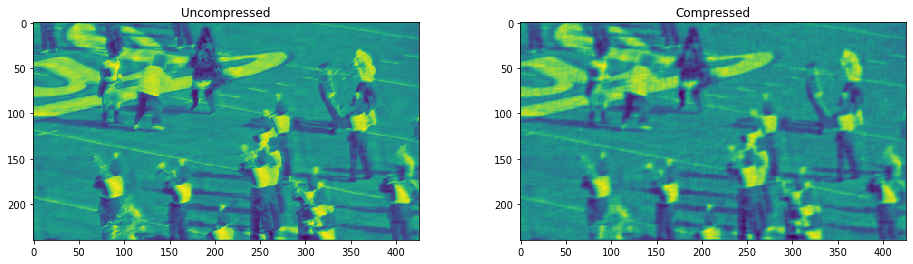

In [18]:
R_re = R_comp.reshape((f,h,w))
R_orig = R.reshape((f,h,w))
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.imshow(R_orig.real[0])
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(R_re.real[0])
plt.title("Compressed")
plt.show()

Not bad! Now let's see how much information is contained by the coefficients we used.

In [19]:
def plot_information(percent_info, num):
    plt.figure(figsize=(14,4))
    plt.plot(np.arange(num)[::10000]/num, percent_info[::10000])
    plt.title("Percentage of Information held by Percentage of Components")
    plt.xlabel("Percentage of Components")
    plt.ylabel("Percentage of Information")
    
def component_vs_info(im, quality = 0.6, display_thresh=True):
    im_sort = np.sort(np.abs(im.flatten()))
    s = np.sum(im_sort)
    num = im.shape[0]*im.shape[1]
    percent_info = np.cumsum(im_sort)/s
    plot_information(percent_info, num)
    if display_thresh:
        thresh = np.argmin(np.abs(percent_info - (1 - quality)))
        print("To retain", quality * 100, "percent quality, we need to remove all values below", im_sort[thresh])
        print("The top",np.round(100*(1-thresh/num),2),"percent of components contain",quality*100,"percent of the information")
        return im_sort[thresh]

To retain 60.0 percent quality, we need to remove all values below 29.85719470791068
The top 7.86 percent of components contain 60.0 percent of the information


29.85719470791068

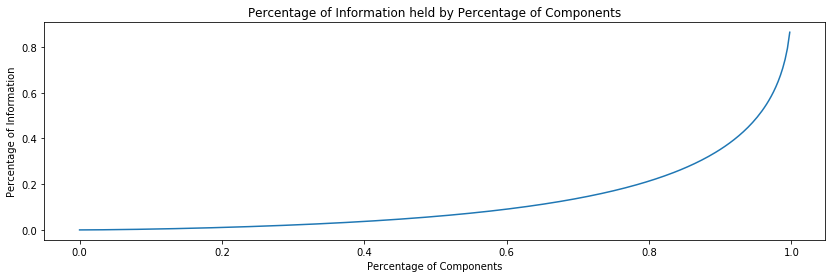

In [20]:
component_vs_info(R_fft)

We used a threshold of 23.2, which corresponds to using only **12.92% of the coefficients**! That seems crazy, but this preserved 60% of the information! This is why transform-based compression methods are so effective: they find a *sparse* representation of signals, so that most of the information is contained in only a few numbers (the coefficients).

Finally, let's actually compress our video using this method and see how the whole thing looks.

In [33]:
def get_threshold(im, quality = 0.6):
    im_sort = np.sort(np.abs(im.flatten()))
    s = np.sum(im_sort)
    percent_info = np.cumsum(im_sort)/s
    thresh = np.argmin(np.abs(percent_info - (1 - quality)))
    return im_sort[thresh]
    
def reconstruct(im, quality = 0.6):
    im_fft = fft2c(im)
    thresh = get_threshold(im_fft, quality)
    im_thresh = garotte_thresh(im_fft, thresh)
    return ifft2c(im_thresh).real

def compress_video(vid, quality = 0.6):
    frames, h, w, channels = vid.shape
    R = vid[:,:,:,0].reshape((frames,h*w))
    G = vid[:,:,:,1].reshape((frames,h*w))
    B = vid[:,:,:,2].reshape((frames,h*w))
    R, G, B = reconstruct(R, quality), reconstruct(G, quality), reconstruct(B, quality)
    R, G, B = np.reshape(R,(frames, h, w)), np.reshape(G,(frames, h, w)), np.reshape(B,(frames, h, w))
    vid_compressed = np.stack((R,G,B), axis = -1)
    skvideo.io.vwrite("oski_tree_compressed.gif", vid_compressed)

In [34]:
compress_video(oski, quality=1.0)


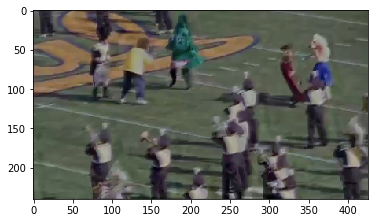

In [27]:
data = skvideo.io.vread("oski_tree_compressed.mp4")
plt.imshow(data[0])

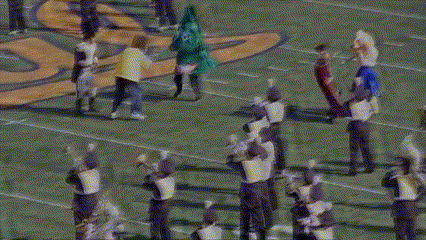

In [40]:
Image("oski_tree_compressed.gif")

Not bad! So, representing things as sines and cosines seems to work alright. But can we do even better?

## Part 2: Wavelet-Based Compression

In Part 1, we said that if we represent videos as a sum of sines and cosines, most of the information, or "weight" will be contained in only a few of the sines and cosines. Indeed, we saw that 60% of the information was contained in just 12-13% of the coefficients. It's not obvious that sines and cosines are the most efficient way to represent images or videos, however. 

For example, let's consider the checkerboard pattern below:

<img src="checkerboard.png" width=150px></img>

Trying to represent this pattern in terms of sines and cosines would yield catastrophic results: due to the sharp transitions between white and black, it would in fact take an **infinite** number of sines and cosines at different frequencies added together to produce this pattern! More generally, sines and cosines suck at dealing with sharp, box-like things. So, instead we can use **Haar functions**, which are just rectangles, which are great at dealing with box-like objects since they are boxes!

More generally, we could use any set of *wavelets*, which is just some set of orthonormal basis functions that we choose so that our data has a sparse representation in that basis. The Haar family is the most popular, however, so we'll use that here.

In [11]:
def get_frames(video_path, downsample=1):
    frames = skvideo.io.vread(video_path)
    if downsample > 1:
        frames = scipy.signal.decimate(frames, q=downsample, ftype='fir', axis=0)
    return frames

def get_haar_wavelet_coefficient_set(frames):
    def dwt2_haar_coefficients(frames, frame_no, color_no):
        return pywt.dwt2(frames[frame_no, :, :, color_no], 'haar')

    haar_coefficient_set = [[None, None, None] for _ in range(len(frames))]
    for frame_no in range(len(frames)):
        for color_no in (0, 1, 2):
            haar_coefficient_set[frame_no][color_no] = dwt2_haar_coefficients(frames, frame_no, color_no)
    return haar_coefficient_set

def threshold_coefficients(haar_coefficient_set, approx_thresh=1000, horiz_thresh=1000, vert_thresh=1000, diag_thresh=1000):
    res = copy.deepcopy(haar_coefficient_set)
    for frame_no in range(len(res)):
        for color_no in (0, 1, 2):
            LL = pywt.threshold(res[frame_no][color_no][0],    approx_thresh, mode='soft', substitute=0)
            LH = pywt.threshold(res[frame_no][color_no][1][0], horiz_thresh,  mode='soft', substitute=0)
            HL = pywt.threshold(res[frame_no][color_no][1][1], vert_thresh,   mode='soft', substitute=0)
            HH = pywt.threshold(res[frame_no][color_no][1][2], diag_thresh,   mode='soft', substitute=0)
            res[frame_no][color_no] = (LL, (LH, HL, HH))
    return res

def get_reconstructed_frames(haar_coefficient_set, original_frames_shape):
    res = np.empty(original_frames_shape, dtype=int)
    for frame_no in range(len(haar_coefficient_set)):
        for color_no in (0, 1, 2):
            res[frame_no, :, :, color_no] = pywt.idwt2(haar_coefficient_set[frame_no][color_no], 'haar')
    return res

def make_video_file(frames, name):
    skvideo.io.vwrite(name, frames, inputdict={'-r': '30',}, outputdict={'-r': '30'})
    
def plot_all_transforms(frames, frame_no, color_no):
    titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
    coeffs = pywt.dwt2(frames[frame_no, :, :, color_no], 'haar')
    LL, (LH, HL, HH) = coeffs
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    
def plot_information(percent_info, num):
    plt.figure(figsize=(7,4))
    plt.plot(np.arange(num)[::10000]/num, percent_info[::10000])
    plt.title("Percentage of Information held by Percentage of Components")
    plt.xlabel("Percentage of Components")
    plt.ylabel("Percentage of Information")

def component_vs_info(im, quality=0.6, display_thresh=True):
    im_sort = np.sort(np.abs(im.flatten()))
    s = np.sum(im_sort)
    num = im.shape[0]*im.shape[1]
    percent_info = np.cumsum(im_sort)/s
    plot_information(percent_info, num)
    if display_thresh:
        thresh = np.argmin(np.abs(percent_info - (1 - quality)))
        print("To retain", quality * 100, "percent quality, we need to remove all values below", im_sort[thresh])
        print("The top",np.round(100*(1-thresh/num),2),"percent of components contain",quality*100,"percent of the information")

def display_frame_transform(frames, frame_no, color_no, detail='approx', quality=0.6):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    LL, (LH, HL, HH) = pywt.dwt2(frames[frame_no, :, :, 0], 'haar')
    fig = plt.figure(figsize=(48, 5))

    if detail == 'approx':
        coeffs = LL
        title = 'Approximation'
    elif detail == 'horiz':
        coeffs = LH
        title = 'Horizontal detail'
    elif detail == 'vert':
        coeffs = HL
        title = 'Vertical detail'
    elif detail == 'diag':
        coeffs = HH
        title = 'Diagonal detail'
    else:
        print('Detail should be approx, horiz, vert, or diag')
        return

    plt.figure(figsize=(14,4))
    plt.imshow(coeffs, interpolation='nearest', cmap=plt.cm.gray)
    plt.title(title, fontsize=10)
    plt.xticks([])
    plt.yticks([])
    component_vs_info(coeffs, quality=quality)

One of the nice things about wavelets is that they pick out different kinds of information based on how they're scaled and stretched. For example, let's look at the different information picked out by the horizontal, vertical, and diagonal "detailed coefficients", as well as the "approximation coefficient".

In [12]:
frames = get_frames('oski_tree.mp4')
plot_all_transforms(frames, 0, 0)

Note how the vertical detail coefficients pick out the features that change across the y-axis, and similarly with the horizontal and diagonal detail coefficients. The approximation coefficients pick out the high-level trends of the image rather than the more detailed coefficients, and thus more closely resembles the actual image. Let's see how information-rich the wavelet coefficients are compared to the DFT coefficients.

To retain 90.0 percent quality, we need to remove all values below 226.00000000000006
The top 80.41 percent of components contain 90.0 percent of the information


<Figure size 3456x360 with 0 Axes>

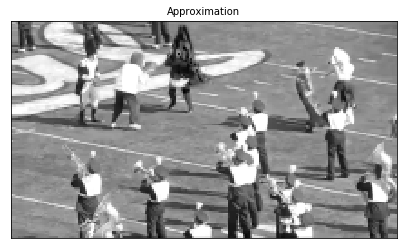

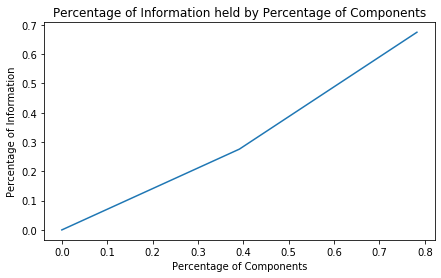

In [13]:
display_frame_transform(frames, 0, 0, detail='approx', quality=0.9);

To retain 75.0 percent quality, we need to remove all values below 13.5
The top 24.03 percent of components contain 75.0 percent of the information


<Figure size 3456x360 with 0 Axes>

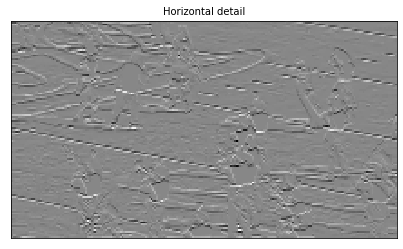

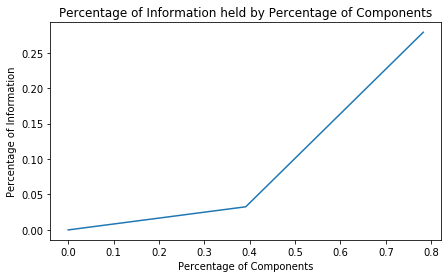

In [14]:
display_frame_transform(frames, 0, 0, detail='horiz', quality=0.75);

To retain 75.0 percent quality, we need to remove all values below 10.0
The top 17.79 percent of components contain 75.0 percent of the information


<Figure size 3456x360 with 0 Axes>

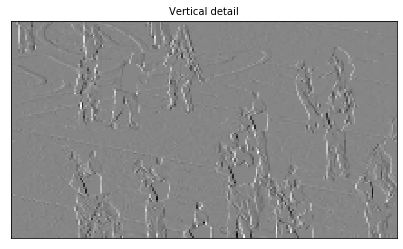

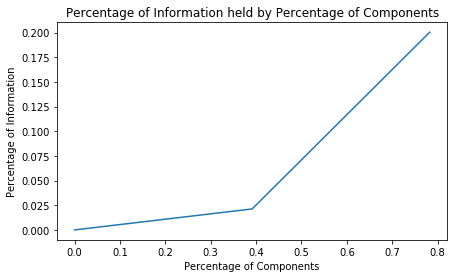

In [15]:
display_frame_transform(frames, 0, 0, detail='vert', quality=0.75);

To retain 75.0 percent quality, we need to remove all values below 3.500000000000007
The top 21.62 percent of components contain 75.0 percent of the information


<Figure size 3456x360 with 0 Axes>

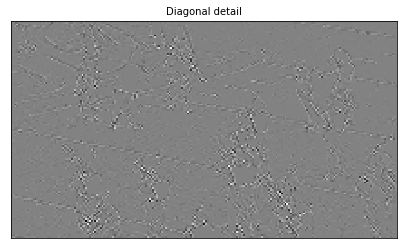

In [16]:
display_frame_transform(frames, 0, 0, detail='diag', quality=0.75);

About the same. The actual numbers will depend on the specific video/image, but generally wavelets contain more information in less coefficients, making them a better basis for compression. Let's see the final video after doing wavelet compression with 90% information retained for the approximation coefficients, and 75% information retained for the other coefficients.

In [17]:
frames = get_frames('oski_tree.mp4', downsample=5) # again, we need to downsample to get the video small enough to process on datahub
hwcs = get_haar_wavelet_coefficient_set(frames)
thresholded = threshold_coefficients(hwcs, approx_thresh=226, horiz_thresh=13.5, vert_thresh=3.5, diag_thresh=10)
recon = get_reconstructed_frames(thresholded, np.shape(frames))

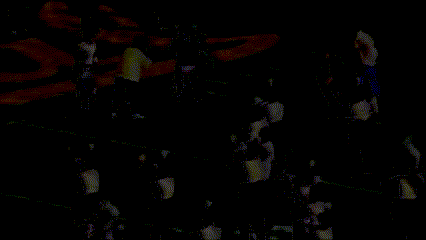

In [18]:
make_video_file(recon, 'recon.gif')
Image('recon.gif')

Note that for lossy wavelet compression, quality reduction manifests as a reduction in brightness. Try playing with the `approx_thresh` value to brighten the compressed video.

# References

[1] *Wavelet Shrinkage Denoising Using the Non-Negative Garotte*. Gao, Hong-Ye. 1997. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.8935&rep=rep1&type=pdf